tgb - 2/7/2019 - Given neural network parametrizations of convection developed in the notebook 002, this notebook aims at calculating two Jacobians:  
1) The Jacobian of the entire neural network parametrization:  
$$
\frac{d\mathrm{Output}}{d\mathrm{Input}}
$$
using the built-in automatic differentiation routines in tensorflow. Adapted from Stephan's devlog at:  
https://github.com/raspstephan/CBRAIN-CAM/blob/tf.keras/notebooks/stephans-devlog/3.6-Compute-tf-model-Jacobian.ipynb  
2) From the first Jacobian, infer the Jacobian of the coupled temperature-moisture dynamical system:
$$
\left(\frac{\partial\dot{\overrightarrow{x}}}{\partial\overrightarrow{x}}\right)_{\overrightarrow{x}=\overrightarrow{x_{0}}}\left[\mathrm{s^{-1}}\right]\ \ \ \ |\ \ \ \ \overrightarrow{x}\left[\mathrm{J\ m^{-2}}\right]\overset{\mathrm{def}}{=}\left[\begin{array}{cc}
c_{p}T\left(t\right) & L_{v}q_{v}\left(t\right)\end{array}\right]^{\mathrm{T}}
$$

# 1) Initialization
## 1.1) Import modules and models, define directories
tgb - 2/7/2019 - [Convo with Stephan R] Because keras is incompatible with eager execution, I have to load tensorflow.keras everywhere (including changes to the cbrain imports/models).

In [1]:
import tensorflow as tf
import tensorflow.math as tfm
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.models import *
from cbrain.utils import limit_mem
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
#PREFIX = '32_col_lgsc_12m_'
PREFIX = '32_col_rad_12m_'
tf.enable_eager_execution()


/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 1.2) Define model
tgb - 2/7/2019 - There will be a bug linked to tf's placeholders (tf.placeholder()) if we import keras instead of tf.keras.

In [2]:
# Load all the variables used to calculate normalizations
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


### 1.2.1) Load model and weights (PREFIX = '32_col_lgsc_12m_')

In [12]:
# Define model
# Conserving model with 5 dense layers using LeakyReLU activation
# Have to define it as a function to avoid placeholders which make no sense since we are immediately executing the model
# See https://github.com/tensorflow/tensorflow/issues/18165 for more information

def cons_5dens(fsub,fdiv,normq,hyai,hybi):
# tgb - 2/7/2019 - Draft of the energy/mass conserving model
# Improve it using fc_model
    inp = Input(shape=(304,))
    densout = Dense(512, activation='linear')(inp)
    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (4):
        densout = Dense(512, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    densout = Dense(156, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
    massout = MasConsLay(
        input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
        hyai=hyai, hybi=hybi, output_dim = 157
    )([inp, densout])
    out = EntConsLay(
        input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
        hyai=hyai, hybi=hybi, output_dim = 158
    )([inp, massout])
    
    return tf.keras.models.Model(inp, out)  

lru_cons_5dens = cons_5dens(fsub,fdiv,normq,hyai,hybi)
lru_cons_5dens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

In [13]:
# Go to directory where models are saved to load weights of model
%cd $TRAINDIR/HDF5_DATA
!ls
# Load model
lru_cons_5dens.load_weights('lru_cons_5dens'+'.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
lru_cons_5dens.h5     lru_uncons_5dens.h5   mod_lagr05_5dens.h5   tmp.h5
lru_lagr001_5dens.h5  mod_cons_5dens.h5     mod_lagr099_5dens.h5
lru_lagr05_5dens.h5   model1.h5		    mod_uncons_5dens.h5
lru_lagr099_5dens.h5  mod_lagr001_5dens.h5  rmsp_cons_5dens.h5


### 1.2.2) Load model and weights (PREFIX = '32_col_rad_12m_')
tgb - 2/23/2019 - Now loads the model predicting radiation and convection separately (defined in notebook 005)

In [3]:
# Conserving model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
sradout = SurRadLay(
    input_shape=(214,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 216
)([inp, densout])
massout = MasConsLay(
    input_shape=(216,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 217
)([inp, sradout])
out = EntConsLay(
    input_shape=(217,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 218
)([inp, massout])
C_rad_5dens = Model(inputs=inp, outputs=out)

In [4]:
# Unconstrained model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
U_rad_5dens = Model(inputs=inp, outputs=out)

In [5]:
# Go to directory where models are saved to load weights of model
%cd $TRAINDIR/HDF5_DATA
!ls
# Load model
C_rad_5dens.load_weights('C_rad_5dens.h5')
U_rad_5dens.load_weights('U_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
C_rad_5dens.h5	      mod_cons_5dens.h5     rmsp_cons_5dens.h5
lru_cons_5dens.h5     model1.h5		    tmp.h5
lru_lagr001_5dens.h5  mod_lagr001_5dens.h5  U_rad_5dens.h5
lru_lagr05_5dens.h5   mod_lagr05_5dens.h5   W001_rad_5dens.h5
lru_lagr099_5dens.h5  mod_lagr099_5dens.h5  W05_rad_5dens.h5
lru_uncons_5dens.h5   mod_uncons_5dens.h5   W099_rad_5dens.h5


## 1.3) Define data generator
tgb - 2/7/2019 - Same than in notebook 002: Training data is first year, validation data is first three months of second year.

In [6]:
# TRAINING generator
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'train_shuffle_features.nc',
    target_fn=PREFIX+'train_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)
gen = train_gen_obj.return_generator()
# Produce data sample
x, y = next(gen)

# VALIDATION generator
valid_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'valid_shuffle_features.nc',
    target_fn=PREFIX+'valid_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)
validgen = valid_gen_obj.return_generator()
# Produce data sample
xval, yval = next(validgen)

Generator will have 9338880 samples in 18240 batches
Features have shape 304; targets have shape 218
Generator will have 3514368 samples in 6864 batches
Features have shape 304; targets have shape 218


# 2) Calculate the Jacobian of the NN using Tensorflow
tgb - 2/7/2019 - Loosely follows  
https://github.com/raspstephan/CBRAIN-CAM/blob/tf.keras/notebooks/stephans-devlog/3.6-Compute-tf-model-Jacobian.ipynb

## 2.1) Check predictions of the model

In [7]:
#pred = lru_cons_5dens(x).numpy()
pred = C_rad_5dens(x).numpy()
a = np.expand_dims(x[0,:],axis=0) 
#pred0 = lru_cons_5dens(a)
pred0 = C_rad_5dens(a)
print(pred0.shape)

(1, 218)


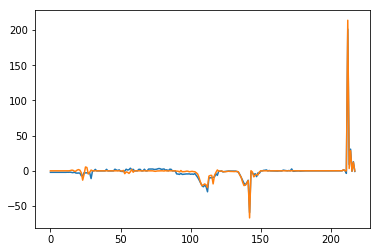

In [8]:
index = np.floor(y.shape[1]*np.random.rand(1)) # Random number between 0 and 158
index = index[0].astype(np.int64) # Convert to integer
plt.plot(pred[index,:])
plt.plot(y[index,:])

## 2.2) Adapt Stephan's get_jacobian function to current workflow
tgb - 2/7/2019 

In [9]:
gen_obj = train_gen_obj
J = np.zeros((gen_obj.target_shape, gen_obj.feature_shape))
J.shape
#print(fdiv)

(218, 304)

In [10]:
with tf.GradientTape() as tape:
    a = np.expand_dims(x[0,:],axis=0) 
    x_tf = tf.convert_to_tensor(a)
    tape.watch(x_tf)
    #pred0 = lru_cons_5dens(x_tf)
    pred0 = C_rad_5dens(x_tf)
    out = pred0[0,0]
    b = tape.gradient(out, x_tf)
    c = fdiv*b
    print(b.shape)
print(pred0.shape)
print(c.shape)

(1, 304)
(1, 218)
(1, 304)


The goal is to calculate the following Jacobian:
$$
J_{ij}\left[\mathrm{s^{-1}}\right]\overset{\mathrm{def}}{=}\frac{d\mathrm{Output}_{i}\left[\mathrm{W\ m^{-2}}\right]}{d\mathrm{Input}_{j}\left[\mathrm{J\ m^{-2}}\right]}
$$
The outputs y are already normalized to W/m2. The normalization of the inputs x by the neural network imply the following differentiation rule:
$$
\mathrm{Input}_{i}^{NORM}\left[1\right]=\frac{\mathrm{Input}_{i}\left[SU\right]-\mathrm{fsub}_{i}\left[SU\right]}{\mathrm{fdiv}_{i}\left[SU\right]}\ \Rightarrow\ d\mathrm{Input}_{i}^{NORM}\left[1\right]=\frac{d\mathrm{Input}_{i}\left[SU\right]}{\mathrm{fdiv}_{i}\left[SU\right]}
$$  
where SU refers to standard units. Meanwhile, we can go from SU to J/m2 using a conversion factor CF:
$$
\mathrm{Input}_{i}\left[\mathrm{J\ m^{-2}}\right]=\mathrm{CF}_{i}\left[\mathrm{J\ m^{-2}\ }SU^{-1}\right]\times\mathrm{Input}_{i}\left[SU\right]\ \Rightarrow\ d\mathrm{Input}_{i}\left[\mathrm{J\ m^{-2}}\right]=\mathrm{CF}_{i}\left[\mathrm{J\ m^{-2}\ }SU^{-1}\right]\times d\mathrm{Input}_{i}\left[SU\right]
$$  
We combine the two differential identities to express the Jacobian in growth rate units as a function of the inputs and outputs of the neural network:
$$
J_{ij}\left[s^{-1}\right]=\frac{1}{\mathrm{fdiv}_{j}\left[SU\right]\times\mathrm{CF}_{j}\left[\mathrm{J\ m^{-2}\ }SU^{-1}\right]}\frac{d\mathrm{Output}_{i}\left[\mathrm{W\ m^{-2}}\right]}{d\mathrm{Input}_{j}^{NORM}\left[1\right]}
$$

In [11]:
def get_jacobian(model,inp,sample_index,gen_obj,fdiv,cf):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
    J = np.zeros((gen_obj.target_shape, gen_obj.feature_shape))
    for i in range(gen_obj.target_shape):
        with tf.GradientTape() as tape:
            x_tf = tf.convert_to_tensor(np.expand_dims(x[sample_index,:],axis=0) )
            tape.watch(x_tf)
            pred = model(x_tf)
            out_i = pred[0, i]
        grads = tape.gradient(out_i, x_tf).numpy()
        J[i, :] = grads/(fdiv*cf)
    return J

tgb - 2/7/2019 - Conversion factor vector  
Inputs are in sample, 304 = 30*10+4] with  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic,
Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
This implies the following conversion factor vector:  
[Lv, Lv, Lv, cp, ?need to square it to make it energy?, Lv * dt, Lv * dt, Lv * dt, cp * dt, ??, ??, dt, dt, dt, dt]

In [12]:
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
dt = 30*60; # Timestep
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
cf = np.zeros((1, train_gen_obj.feature_shape))
for index in range (train_gen_obj.feature_shape):
    if index<90: cf[0,index]=L_V;
    elif index<120: cf[0,index]=C_P;
    elif index<150: cf[0,index]=1;
    elif index<240: cf[0,index]=L_V*dt;
    elif index<270: cf[0,index]=C_P*dt;
    elif index<301: cf[0,index]=1;
    else: cf[0,index]=dt;

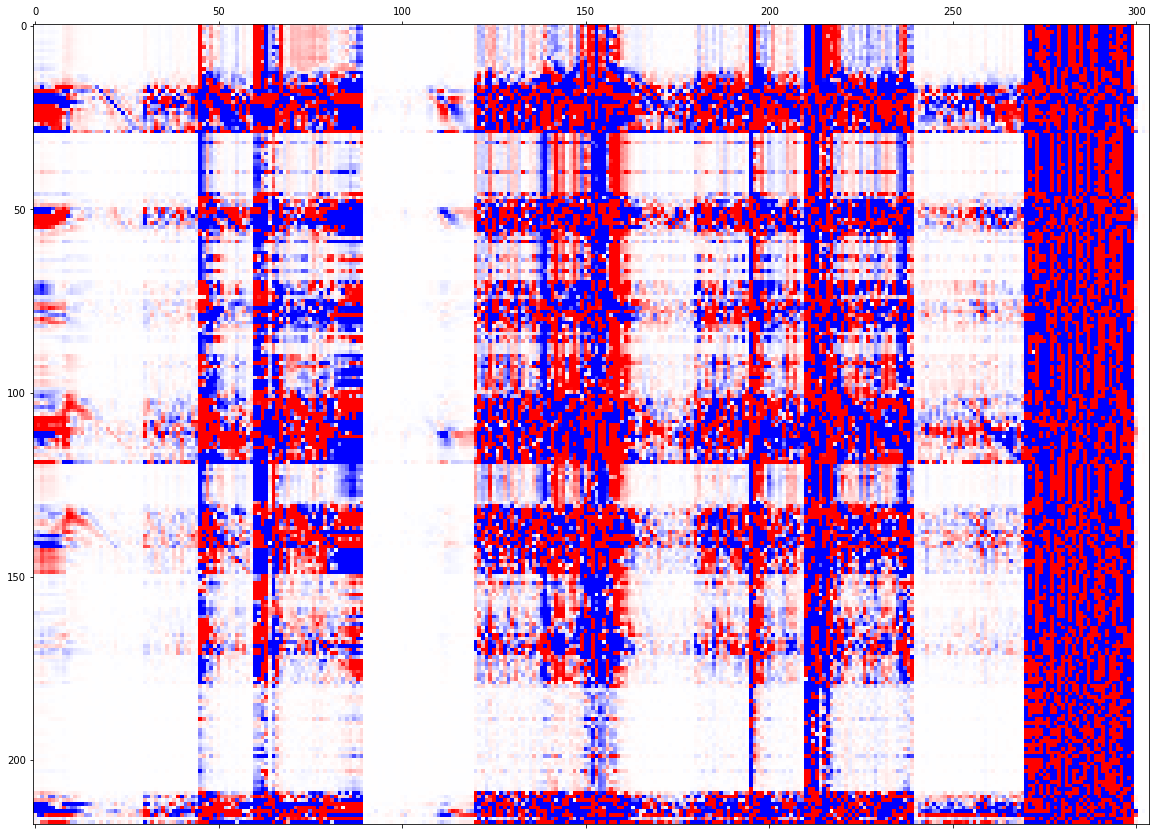

In [13]:
index = np.floor(y.shape[1]*np.random.rand(1)) # Random number between 0 and 158
index = index[0].astype(np.int64) # Convert to integer
#J = get_jacobian(lru_cons_5dens,x,index,train_gen_obj,fdiv,cf)
J = get_jacobian(C_rad_5dens,x,index,train_gen_obj,fdiv,cf)
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(J, vmin=-0.01, vmax=0.01, cmap='bwr')

# 3) Get (Temperature,Moisture) Jacobian

## 3.1) Calculation from full Jacobian

### 3.1.1) Convection

In [14]:
# d( dq/dt , dT/dt )/d( q , T )
JTQ = np.zeros((60,60))
for i in range (60):
    for j in range(60):
        if (i<30) and (j<30): JTQ[i,j] = J[i,j] # d(dq/dt)/dq
        elif (i>29) and (j<30): JTQ[i,j] = J[90+(i-30),j]-J[120+(i-30),j]-J[150+(i-30),j] # d(dTcon/dt)/dq
        elif (i<30) and (j>29): JTQ[i,j] = J[i,90+(j-30)] # d(dq/dt)/dT
        elif (i>29) and (j>29): JTQ[i,j] = J[90+(i-30),90+(j-30)]-J[120+(i-30),90+(j-30)]-J[150+(i-30),90+(j-30)] # d(dTcon/dt)/dT


In [15]:
print(J[29,9])
print(JTQ[50,50])

-0.01516890793398518
-0.00044738512367350775


### 3.1.2) Longwave and shortwave radiation

In [16]:
# d( LW , SW )/d( q , T )
JRAD = np.zeros((60,60))
for i in range (60):
    for j in range(60):
        if (i<30) and (j<30): JRAD[i,j] = J[120+i,j]
        elif (i>29) and (j<30): JRAD[i,j] = J[150+(i-30),j]
        elif (i<30) and (j>29): JRAD[i,j] = J[120+i,90+(j-30)]
        elif (i>29) and (j>29): JRAD[i,j] = J[150+(i-30),90+(j-30)]

### 3.1.3) Plot

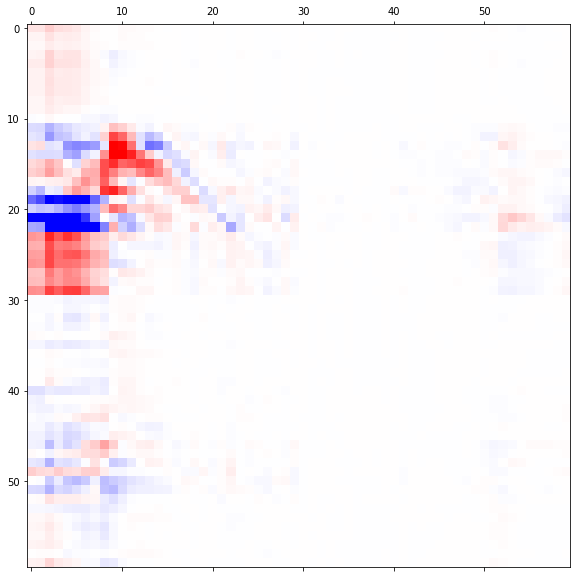

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(JRAD, vmin=-0.01, vmax=0.01, cmap='bwr')

### 3.1.4) Create corresponding functions

In [18]:
def get_TQjacobian(model,inp,sample_index,gen_obj,fdiv,cf):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
    J = np.zeros((gen_obj.target_shape, gen_obj.feature_shape))
    for i in range(gen_obj.target_shape):
        with tf.GradientTape() as tape:
            x_tf = tf.convert_to_tensor(np.expand_dims(x[sample_index,:],axis=0) )
            tape.watch(x_tf)
            pred = model(x_tf)
            out_i = pred[0, i]
        grads = tape.gradient(out_i, x_tf).numpy()
        J[i, :] = grads/(fdiv*cf)
    
    JTQ = np.zeros((60,60))
    for i in range (60):
        for j in range(60):
            if (i<30) and (j<30): JTQ[i,j] = J[i,j] # d(dq/dt)/dq
            elif (i>29) and (j<30): JTQ[i,j] = J[90+(i-30),j]-J[120+(i-30),j]-J[150+(i-30),j] # d(dTcon/dt)/dq
            elif (i<30) and (j>29): JTQ[i,j] = J[i,90+(j-30)] # d(dq/dt)/dT
            elif (i>29) and (j>29): JTQ[i,j] = J[90+(i-30),90+(j-30)]-J[120+(i-30),90+(j-30)]-J[150+(i-30),90+(j-30)] # d(dTcon/dt)/dT

    
    return JTQ

In [19]:
def get_RADjacobian(model,inp,sample_index,gen_obj,fdiv,cf):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
    J = np.zeros((gen_obj.target_shape, gen_obj.feature_shape))
    for i in range(gen_obj.target_shape):
        with tf.GradientTape() as tape:
            x_tf = tf.convert_to_tensor(np.expand_dims(x[sample_index,:],axis=0) )
            tape.watch(x_tf)
            pred = model(x_tf)
            out_i = pred[0, i]
        grads = tape.gradient(out_i, x_tf).numpy()
        J[i, :] = grads/(fdiv*cf)
    
    JRAD = np.zeros((60,60))
    for i in range (60):
        for j in range(60):
            if (i<30) and (j<30): JRAD[i,j] = J[120+i,j]
            elif (i>29) and (j<30): JRAD[i,j] = J[150+(i-30),j]
            elif (i<30) and (j>29): JRAD[i,j] = J[120+i,90+(j-30)]
            elif (i>29) and (j>29): JRAD[i,j] = J[150+(i-30),90+(j-30)]

    
    return JRAD

## 3.2) Iterate over several basic states to obtain physically-meaningful Jacobian

In [20]:
tmp = np.zeros((60,60))
tmp = tmp[..., np.newaxis]
N_iteration = 100
JTQ_full = np.tile(tmp, N_iteration)
JRAD_full = np.tile(tmp, N_iteration)
for index in range(N_iteration):
    print(index)
    x, y = next(gen)
    JTQ_full[:,:,index] = get_TQjacobian(C_rad_5dens,x,index,train_gen_obj,fdiv,cf)
    JRAD_full[:,:,index] = get_RADjacobian(C_rad_5dens,x,index,train_gen_obj,fdiv,cf)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [21]:
JTQ_mean = np.mean(JTQ_full, axis=2)
JTQ_mean.shape
JRAD_mean = np.mean(JRAD_full, axis=2)

[Text(0, 0, '$\\mathrm{LW_{200hPa}}$'),
 Text(0, 0, '$\\mathrm{LW_{500hPa}}$'),
 Text(0, 0, '$\\mathrm{LW_{850hPa}}$'),
 Text(0, 0, '$\\mathrm{LW_{967hPa}}$'),
 Text(0, 0, '$\\mathrm{SW_{350hPa}}$'),
 Text(0, 0, '$\\mathrm{SW_{730hPa}}$'),
 Text(0, 0, '$\\mathrm{SW_{925hPa}}$'),
 Text(0, 0, '')]

<Figure size 1600x1080 with 0 Axes>

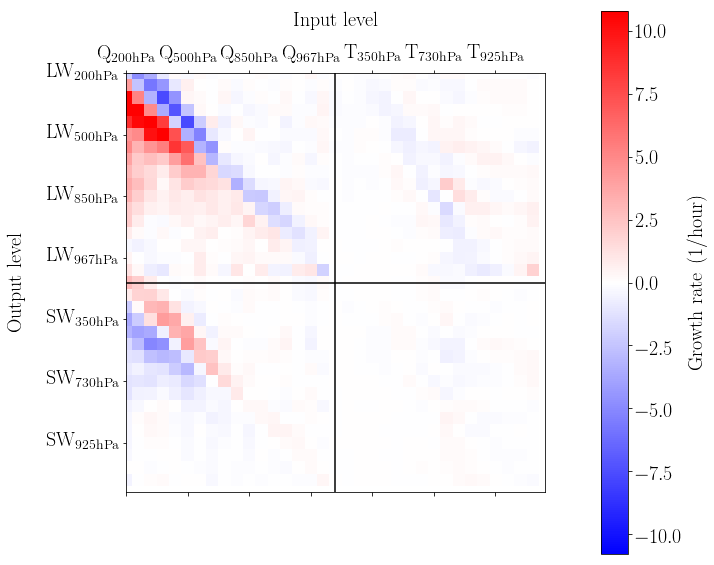

In [80]:
minlev = 200; # Minimum level [hPa]
plot_option = 'RAD'
if plot_option=='RAD': J = JRAD_mean
elif plot_option=='CON': J = JTQ_mean

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots(figsize=(10,10))
# Extract the Jacobian from level minlev to the surface (index 30 here)
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
minind = np.argmin(abs(P-minlev*1e2));
IND = np.concatenate((np.arange(minind,30),np.arange(30+minind,60)),axis=0)
J = J[IND,:]; J = J[:,IND];
cax = ax.matshow(3600*J, vmin=-3600*0.003, vmax=3600*0.003, cmap='bwr')

x = np.linspace(0.,60.,100);
plt.plot(x,J.shape[0]/2*x**0, color='k')
plt.plot(J.shape[0]/2*x**0,x, color='k')

plt.xlim((0,J.shape[0])); plt.ylim((J.shape[0],0))

cbar = fig.colorbar(cax, pad = 0.1)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/hour\right)}$', rotation=90, fontsize = 20)

plt.xticks(fontsize=20); plt.yticks(fontsize=20)
ax.xaxis.set_label_position('top')
X = plt.xlabel(r'Input level', fontsize = 20)
ax.xaxis.labelpad = 20
Y = plt.ylabel(r'Output level', fontsize = 20)
ax.yaxis.labelpad = 20

# fig.canvas.draw()
labelx = [item.get_text() for item in ax.get_xticklabels()]
# labelx[0] = '$\mathrm{QV_{0hPa}}$'
# labelx[1] = '$\mathrm{QV_{130hPa}}$'
# labelx[2] = '$\mathrm{QV_{650hPa}}$'
# labelx[3] = '$\mathrm{T_{0hPa}}$'
# labelx[4] = '$\mathrm{T_{130hPa}}$'
# labelx[5] = '$\mathrm{T_{650hPa}}$'
# labelx[6] = '$\mathrm{T_{1000hPa}}$'
labelx[0] = '$\mathrm{Q_{200hPa}}$'
labelx[1] = '$\mathrm{Q_{500hPa}}$'
labelx[2] = '$\mathrm{Q_{850hPa}}$'
labelx[3] = '$\mathrm{Q_{967hPa}}$'
labelx[4] = '$\mathrm{T_{350hPa}}$'
labelx[5] = '$\mathrm{T_{730hPa}}$'
labelx[6] = '$\mathrm{T_{925hPa}}$'
labely = [item.get_text() for item in ax.get_yticklabels()]
if plot_option=='RAD':
#     labely[0] = '$\mathrm{LW_{0hPa}}$'
#     labely[1] = '$\mathrm{LW_{130hPa}}$'
#     labely[2] = '$\mathrm{LW_{650hPa}}$'
#     labely[3] = '$\mathrm{SW_{0hPa}}$'
#     labely[4] = '$\mathrm{SW_{130hPa}}$'
#     labely[5] = '$\mathrm{SW_{650hPa}}$'
#     labely[6] = '$\mathrm{SW_{1000hPa}}$'
    labely[0] = '$\mathrm{LW_{200hPa}}$'
    labely[1] = '$\mathrm{LW_{500hPa}}$'
    labely[2] = '$\mathrm{LW_{850hPa}}$'
    labely[3] = '$\mathrm{LW_{967hPa}}$'
    labely[4] = '$\mathrm{SW_{350hPa}}$'
    labely[5] = '$\mathrm{SW_{730hPa}}$'
    labely[6] = '$\mathrm{SW_{925hPa}}$'
elif plot_option=='CON':
#     labely[0] = '$\mathrm{\dot{QV}_{0hPa}}$'
#     labely[1] = '$\mathrm{\dot{QV}_{130hPa}}$'
#     labely[2] = '$\mathrm{\dot{QV}_{650hPa}}$'
#     labely[3] = '$\mathrm{\dot{T}_{0hPa}}$'
#     labely[4] = '$\mathrm{\dot{T}_{130hPa}}$'
#     labely[5] = '$\mathrm{\dot{T}_{650hPa}}$'
#     labely[6] = '$\mathrm{\dot{T}_{1000hPa}}$'
    labely[0] = '$\mathrm{\dot{Q}_{200hPa}}$'
    labely[1] = '$\mathrm{\dot{Q}_{500hPa}}$'
    labely[2] = '$\mathrm{\dot{Q}_{850hPa}}$'
    labely[3] = '$\mathrm{\dot{Q}_{967hPa}}$'
    labely[4] = '$\mathrm{\dot{T}_{350hPa}}$'
    labely[5] = '$\mathrm{\dot{T}_{730hPa}}$'
    labely[6] = '$\mathrm{\dot{T}_{925hPa}}$'

ax.set_xticklabels(labelx)
ax.set_yticklabels(labely)

In [76]:
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
P[IND[30-17]]/1e2

924.9644624069333

In [68]:
P(IND[0])

TypeError: 'numpy.ndarray' object is not callable

## 3.3) Eigenvalues and eigenmodes of (T,q) Jacobian

tgb - 2/7/2019 - For now adapted from Stephan for meeting.

In [259]:
Eval, Evec = LA.eig(JTQ_mean)

<BarContainer object of 60 artists>

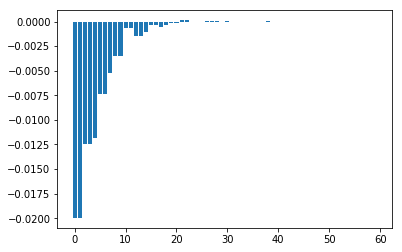

In [285]:
plt.bar(range(60), np.real(Eval))

Text(0.5, 0, 'Level (1=TOA, 30=SURF) for q(left)/T(right)')

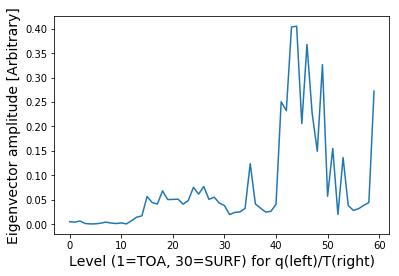

In [296]:
Eind_max = np.argmax(np.real(Eval))
plt.plot(np.abs(Evec[:,Eind_max])) # the index comes in second for M*V=lam*V
plt.ylabel('Eigenvector amplitude [Arbitrary]',fontsize=14)
plt.xlabel('Level (1=TOA, 30=SURF) for q(left)/T(right)', fontsize=14)

In [281]:
eigmax = np.zeros((N_iteration,1))
for index in range (N_iteration):
    Eval, Evec = LA.eig(JTQ_full[:,:,index])
    eigmax[index,0] = np.max(np.real(Eval))
    

0.0007394920903665906
0.00013516901368458063


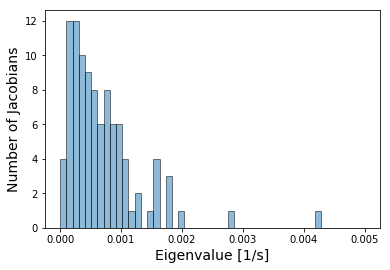

In [301]:
bins = np.linspace(0, 0.005, 50)
plt.hist(eigmax, bins, alpha=0.5, edgecolor='k')
plt.ylabel('Number of Jacobians', fontsize=14)
plt.xlabel('Eigenvalue [1/s]', fontsize=14)
print(np.mean(eigmax))
print(np.max(np.real(Eval)))

In [294]:
print(1/np.max(np.real(Eval)))

7398.145275614116
